# StyleGAN2-ADA

```
Step 1. Initial Setting and load pre-trained model
     1-a. import libraries
     1-b. clone the stylegan2-ada's git repository
     1-c. load pre-trained model that trained on afhqdog dataset
Step 2. generate sample fake-dog images
     2-a. a quick look at the model
     2-b. try submodels : g_mapping, g_synthesis
Step 3. image morphing
     3-a. create 2 random vector z and 2 intermediate latent space w
     3-b. generate 2 target fake-dog images
     3-c. control `z` and try image interpolation


4. get age vecmtor (latent1 - latent2)
5. get another image
```

### Step 1. Initial Setting and load pre-trained model

**1-a. Import Libraries**

In [1]:
import torch
import torchvision

import numpy as np

import pickle

import matplotlib.pyplot as plt

**1-b. clone the `stylegan2-ada`'s git repository**

In [2]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [3]:
%cd stylegan2-ada-pytorch

/kaggle/working/stylegan2-ada-pytorch


In [4]:
!ls

Dockerfile	 dataset_tool.py  generate.py	style_mixing.py
LICENSE.txt	 dnnlib		  legacy.py	torch_utils
README.md	 docker_run.sh	  metrics	train.py
calc_metrics.py  docs		  projector.py	training


In [5]:
!ls ../../input

afhq-dog-pretrained  animal-faces


**1-c. load pre-trained model that trained on `afhqdog` dataset**

In [6]:
with open('../../input/afhq-dog-pretrained/afhqdog.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

### Step 2. generate sample fake-dog images

**2-a. A quick look at the model**

The image generator `G` can be used like this :

In [141]:
z = torch.randn([1, G.z_dim]).cuda()
c = None
img = G(z,c)

In [142]:
img.size()

torch.Size([1, 3, 512, 512])

In [143]:
torch.min(img)

tensor(-1.1742, device='cuda:0')

In [144]:
img.squeeze(0).size()

torch.Size([3, 512, 512])

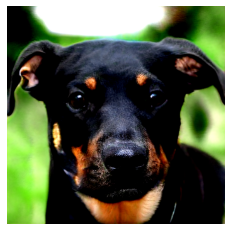

In [145]:
plt.imshow((img+0.5).cpu().squeeze(0).permute(1,2,0))
plt.axis('off')
plt.show();

**2-b. Try submodels : g_mapping, g_synthesis**

It is also possible to divide the G model into submodels.
- we will use this method in more detail, since we plan to adjust the latent vector later

In [12]:
g_mapping = G.mapping
g_synthesis = G.synthesis

Let's take a look at the model structure to see how it is implemented

In [13]:
g_mapping

MappingNetwork(
  (fc0): FullyConnectedLayer()
  (fc1): FullyConnectedLayer()
  (fc2): FullyConnectedLayer()
  (fc3): FullyConnectedLayer()
  (fc4): FullyConnectedLayer()
  (fc5): FullyConnectedLayer()
  (fc6): FullyConnectedLayer()
  (fc7): FullyConnectedLayer()
)

In [14]:
g_synthesis

SynthesisNetwork(
  (b4): SynthesisBlock(
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b8): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b16): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b32): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (conv1): SynthesisLayer(
      (affine): FullyConnectedLayer()
    )
    (torgb): ToRGBLayer(
      (affine): FullyConnectedLayer()
    )
  )
  (b64): SynthesisBlock(
    (conv0): SynthesisLayer(
      (affine): FullyConnec

make latent vector(space) `z` from random gaussian distribution

In [15]:
z = torch.randn([1, G.z_dim]).cuda()
z.size()

torch.Size([1, 512])

transforms `z` into the intermediate latent space `w` (disentangled space)

In [16]:
w = g_mapping(z, None)
w.size()

torch.Size([1, 16, 512])

Now pass `w`(transformed `z`) through the synthesis network to create the `fake image`

In [17]:
img = g_synthesis(w)
img = img.cpu()
img = img.squeeze(0)
img.size()

torch.Size([3, 512, 512])

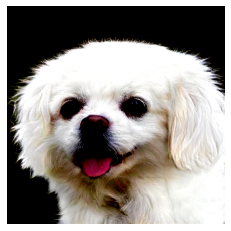

In [18]:
plt.imshow((img+0.3).permute(1,2,0))
plt.axis('off')
plt.show();

### Step 3. image morphing

Image Morphing | meaning
- (computing) The smooth transformation of one image into another


**3-a. create 2 random vector `z` and 2 intermediate latent space `w`**

In [131]:
z1 = torch.randn([1, G.z_dim]).cuda()
z2 = torch.randn([1, G.z_dim]).cuda()

w1 = g_mapping(z1, None)
w2 = g_mapping(z2, None)

**3-b. generate 2 target fake-dog images**

In [146]:
img1 = g_synthesis(w1)
img2 = g_synthesis(w2)

img1 = img1
img1 = img1.squeeze().permute(1,2,0)

img2 = img2
img2 = img2.squeeze().permute(1,2,0)

In [133]:
imgs = torch.cat([img1,img2], axis=1).cpu()
imgs.size()

torch.Size([512, 1024, 3])

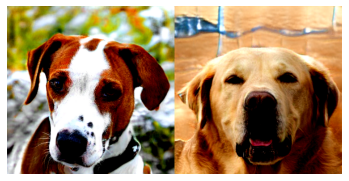

In [134]:
plt.imshow(imgs+0.3) # Increase the brightness by adding 0.3 to the pixel values
plt.axis('off')
plt.show()

**3-c. control `z` and try image interpolation**

In [135]:
img_group = []
lin = np.linspace(0, 1, 10)
print(*lin) # unpack the list

0.0 0.1111111111111111 0.2222222222222222 0.3333333333333333 0.4444444444444444 0.5555555555555556 0.6666666666666666 0.7777777777777777 0.8888888888888888 1.0


In [136]:
with torch.no_grad():
    for i in lin:
        w = ((1-i) * w1) + (i * w2) # style transfrom in for-loop : w1 --> w2
        result = g_synthesis(w)
        result = result.squeeze()
        img_group.append(result)

In [137]:
img_group = torch.cat(img_group).cpu()
img_group.size()

torch.Size([30, 512, 512])

This form is not an image. Let's change the shape to `NxCxHxW` and make it an image

In [138]:
img_group = img_group.view(10,3,512,512)
img_group.size()

torch.Size([10, 3, 512, 512])

And since we will represent the entire image with one image, let's represent 10(`N`) images as a grid.

In [139]:
grid_img = torchvision.utils.make_grid(img_group, nrow=5)
grid_img.size()

torch.Size([3, 1030, 2572])

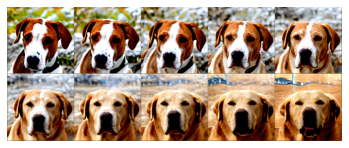

In [140]:
plt.imshow(grid_img.permute(1,2,0) +0.3) # The brightness value was also given by 0.3.
plt.axis('off')
plt.show()